# Цифровой прорыв 2022

**Описание данных.** 

train.csv — файл содержащий данные пользователей для тренировки. Где:
- 1 - клиент ушел,
- 0 - остался.

log.csv — содержит данные обращений пользователей в компаию

named.csv — содержит логи днс-запросов к доменам конкурентов (rt.ru и sampo.ru) \

type contract.csv - тип списания оплаты у пользователей, где: 
- 1 - посуточная,
- 0 - помесячная.

submission.csv — пример файла для отправки и id тестовых пользователей


Метрика baselin'a (Recall score): 0.49873817034700313

In [1]:
#Импорт библиотек и алгоритмов

import pandas as pd

In [2]:
df_train = pd.read_csv("train.csv") #данные для тренировки id и факт ухода
df_type_contract = pd.read_csv("type_contract.csv") #данные о типе списания

df_concurent_logs = pd.read_csv('named.csv')
df_relative_logs = pd.read_csv("log.csv") #обращения клиентов в кампанию

df_sample_solution = pd.read_csv("sample_solution.csv") #образец

df_type_contract.drop_duplicates(inplace = True)
df_concurent_logs.drop_duplicates(inplace = True)

## Дубликаты и пропуски. Выводы рассмотрения

### Дубликаты

**df_concurent_logs (логи днс-запросов к конкурентам)**

Содержит дубликатов 2989415, что составляет 28% от полученных данных
Дубликаты регистрировались по обоим месяцам, представленным в наборе данных (марте, апрель). **Возможно есть неполадки в регистрации логов** —данную гипотезу необходимо проверить, чтобы избежать бессмысленнного увеличения необходимого места для таких данных логов. 


**df_type_contract (тип списания у клиента)**

Содержит дубликатов 5.
Гипотеза: человеческий фактор — ошибка сотрудника при внеении данных в базу данных


**Остальные наборы данных дубликатов не содержат** 

### Пропуски, недостающие части в данных

**Тип контракта** отстсвует для двух тренировчных id (df_type_contract)

**Логи конкурентов** отсутствуют для 3077 (51.35%) тренировочных id и для 3497 (48.5%) из всех доступных id (тестовые + тренировочные)

**Родные логи** (обращения в компанию) отсутствуют для 2183 (36.4%) тренировочных id и для 2491 (36.6%) из всех доступных id 

**Гипотеза:** все вышеперечисленные недостаточные части вызваны небольшим life time value клиента в компании, то есть  если логов нет, то клиент просто не имел проблем/не делал обращений к доменам конкурентов. Однако, для выявления точной причины необходимо понимание, когда пользователь стал клиентом Ситилинка и пониман.  



In [3]:
#Дату и время сражу кастую к релевантному типу, прочитались как строки

df_concurent_logs['date'] = pd.to_datetime(df_concurent_logs['date'])
df_relative_logs['event_date'] = pd.to_datetime(df_relative_logs['event_date'])

# Извлечение признаков из данных о логах к конкурентам

На признаках по логам конкурентов сделан небольшой акцент, поскольку первое рассмотрение данных показало наихудшее качество полученных данных — 28% дубликатов и присутвие возможного признака только для 51.5% от общего количество наблюдений. 

Важно уточнить:  может ли быть такое, что клиент вообще ни разу не генерировал логов на сайтах конкурентов за всю свою life time value в компании?

**Извлеченные признаки:**

- количество логов к конкурентам

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from scipy.stats import chi2_contingency

def schow_feature_boxplots(feature_data, feature, chi2=False):
    
    feature_data_merged = feature_data.merge(df_train, on='contract_id', how='right')
    
    ax = sns.boxplot(data=feature_data_merged, x='blocked', y=feature)
    plt.show()
    
    feature_subdata_1 = feature_data_merged.query('blocked == 1')
    feature_subdata_0 = feature_data_merged.query('blocked == 0')
    
    print('Статистики для группы blocked == 1')
    
    display(feature_subdata_1.describe()[[feature]])
    print('Медиана:', feature_subdata_1[feature].median())
    
    print(f'% пропусков в признаке для группы 1: \
          \n{round(feature_subdata_1[feature].isna().sum()/len(feature_subdata_1)*100, 1)}')
    
    print()
    
    print('Статистики для группы blocked == 0')
    
    display(feature_subdata_0.describe()[[feature]])
    print('Медиана:', feature_subdata_0[feature].median())
    
    print(f'% пропусков в признаке для группы 0: \
           \n{round(feature_subdata_0[feature].isna().sum()/len(feature_subdata_0)*100, 1)}')
    
    #chi2, нулевая гипотеза связи между переменными и группами нет
    
    if chi2 == True:
        data = pd.crosstab(feature_data_merged['blocked'], feature_data_merged[feature])
        stat, p, dof, expected = chi2_contingency(data)
    
        alpha = 0.05
        print('Нулевая гипотеза: нет связи между переменными и группами ')
        print ( "p value равно " + str (p))
        if p <= alpha:
            print ( 'Отклонить нулевую гипотезу' )
        
        else :
            print ('Нулевая гипотеза верна')
    
    return ax

**Анализ потенциального признака количество логов.**

In [5]:
#Датасет, который будет содержать логи конкурентов

concurent_logs_features = df_concurent_logs.copy()

#Формирование признака Количество логов. 
concurent_logs_features = pd.DataFrame(concurent_logs_features.groupby('contract_id').count()['date']).reset_index()
concurent_logs_features.rename({'date':'concurent_logs_count'}, axis=1, inplace=True)

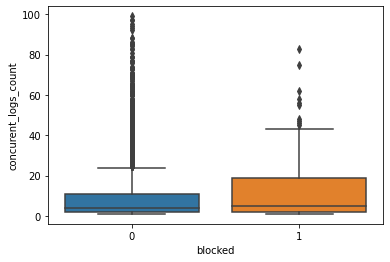

Статистики для группы blocked == 1


,concurent_logs_count
count,157.000000
mean,12.662420
std,15.964927
min,1.000000
25%,2.000000
50%,5.000000
75%,19.000000
max,83.000000


Медиана: 5.0
% пропусков в признаке для группы 1:           
77.5

Статистики для группы blocked == 0


,concurent_logs_count
count,2703.000000
mean,10.216426
std,14.875008
min,1.000000
25%,2.000000
50%,4.000000
75%,11.000000
max,99.000000


Медиана: 4.0
% пропусков в признаке для группы 0:            
48.9


<AxesSubplot:xlabel='blocked', ylabel='concurent_logs_count'>

In [6]:
schow_feature_boxplots(concurent_logs_features.query('concurent_logs_count <100'), 'concurent_logs_count', False)

In [7]:
concurent_logs_features.merge(df_train, how='right').query('blocked==0')['concurent_logs_count'].quantile(0.80)

17.0

Высокий процент пропусков как для целевой, так и для нулевой группы. 
Заполнение, например нулями, чревато скосом среднего. Есть клиенты с подозрительно высоким количеством логов конкурентов, однако аномальность таких данных требует уточнения специалиста тк разнообразие собираемых ссылок, с которых можно получить запрос велико — 6583 уникальных в этом наборе данных.

Для группы оставшихся характерно для 95% наблюдений характерно количество запросов до 52, для 75% до 12, для 80% до 17 (верхняя граница синего квадарата). 

**Признак использовался в лучшей модели**

In [8]:
#Сформируем также признак "Больше 17 запросов"

concurent_logs_features['concurent_logs_count_flag'] = concurent_logs_features['concurent_logs_count'].apply(
                                                        lambda x: 1 if x > 17 else 0)

**Анализ потенциального признака количество логов по конкурентам (сампо, рт).**

In [9]:
#Формирую флаг, сампо или рт

df_concurent_logs['sampo_feature'] =  df_concurent_logs['url'].apply(lambda x: 1 if 'sampo' in x else 0)
df_concurent_logs['rt_feature'] =  df_concurent_logs['url'].apply(lambda x: 1 if 'rt' in x else 0)



In [10]:
concurent_logs_features = concurent_logs_features.merge(df_concurent_logs.groupby(
    'contract_id').sum()[['sampo_feature',  'rt_feature']].reset_index(), how='outer', on='contract_id')


concurent_logs_features.rename({'sampo_feature': 'total_sampo_logs', 'rt_feature': 'total_rt_logs'}, 
                               axis=1, inplace=True)

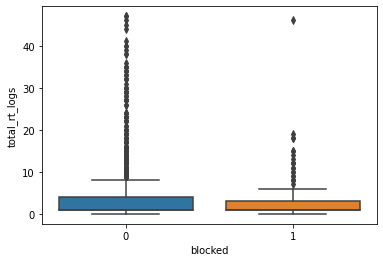

Статистики для группы blocked == 1


,total_rt_logs
count,156.000000
mean,3.134615
std,5.284288
min,0.000000
25%,1.000000
50%,1.000000
75%,3.000000
max,46.000000


Медиана: 1.0
% пропусков в признаке для группы 1:           
77.7

Статистики для группы blocked == 0


,total_rt_logs
count,2733.000000
mean,3.129162
std,5.303505
min,0.000000
25%,1.000000
50%,1.000000
75%,4.000000
max,47.000000


Медиана: 1.0
% пропусков в признаке для группы 0:            
48.4


<AxesSubplot:xlabel='blocked', ylabel='total_rt_logs'>

In [11]:
schow_feature_boxplots(concurent_logs_features.query('total_rt_logs < 50'),'total_rt_logs', False)

Для группы оставшихся (0) более характерно большее количество запросов к rt.ru. 

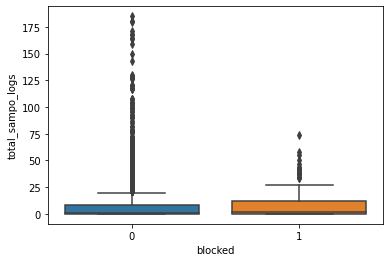

Статистики для группы blocked == 1


,total_sampo_logs
count,157.000000
mean,9.471338
std,14.478791
min,0.000000
25%,0.000000
50%,2.000000
75%,12.000000
max,74.000000


Медиана: 2.0
% пропусков в признаке для группы 1:           
77.5

Статистики для группы blocked == 0


,total_sampo_logs
count,2745.000000
mean,8.468852
std,19.199425
min,0.000000
25%,0.000000
50%,1.000000
75%,8.000000
max,185.000000


Медиана: 1.0
% пропусков в признаке для группы 0:            
48.1


<AxesSubplot:xlabel='blocked', ylabel='total_sampo_logs'>

In [12]:
schow_feature_boxplots(concurent_logs_features.query('total_sampo_logs < 200'),
                       'total_sampo_logs', False)

Для группы оставшихся (0) также остается явным паттерн большего количества логов к sampo.ru. Однако для группы ушедших (1) постоянное количество запросов более широко, но это может быть вызвано в целом присутствием в наборе данных большего числа наблюдений с классом 1. 

Оба признака в модели избыточны. 

**Признак факта регистрации лога конкуренов для contract_id.**


In [13]:
id_with_registered_concurent_logs = list(concurent_logs_features.contract_id.values)

In [14]:
#Признак факта регистрации лога конкуренов для contract_id

df_train['have_concurent_log'] = df_train['contract_id'].apply(
                                  lambda x: 1 if x in id_with_registered_concurent_logs else 0)

df_sample_solution['have_concurent_log'] = df_sample_solution['contract_id'].apply(
                                   lambda x: 1 if x in id_with_registered_concurent_logs else 0)

**Признак количества зарегестрированных уникальных логов для contract_id**

In [15]:
#Анализ таблицы сопряженности
data_to_chi2 = pd.crosstab(df_train.blocked, df_train.have_concurent_log)

stat, p, dof, expected = chi2_contingency(data_to_chi2)
    
alpha = 0.05
print('Нулевая гипотеза: нет связи между переменными и группами ')
print ( "p value равно " + str (p))
    
if p <= alpha:
    
    print ('Отклонить нулевую гипотезу')
        
else :
    print ('Нулевая гипотеза верна')
    
#Переменная оставлена

Нулевая гипотеза: нет связи между переменными и группами 
p value равно 1.0287554102267704e-48
Отклонить нулевую гипотезу


In [16]:
concurent_logs_features['unique_concurents_logs_count'] = [len(i) 
                        for i in df_concurent_logs.groupby('contract_id')['url'].apply(set)]

In [17]:
concurent_logs_features.head()

,contract_id,concurent_logs_count,concurent_logs_count_flag,total_sampo_logs,total_rt_logs,unique_concurents_logs_count
0,3455,23,1,19,4,10
1,3458,1,0,0,1,1
2,3459,2,0,1,1,2
3,3460,4,0,4,0,3
4,3461,1,0,0,1,1


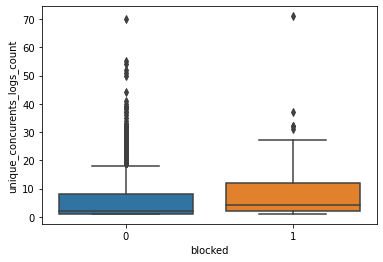

Статистики для группы blocked == 1


,unique_concurents_logs_count
count,157.000000
mean,8.394904
std,9.926498
min,1.000000
25%,2.000000
50%,4.000000
75%,12.000000
max,71.000000


Медиана: 4.0
% пропусков в признаке для группы 1:           
77.5

Статистики для группы blocked == 0


,unique_concurents_logs_count
count,2758.000000
mean,5.824148
std,7.505232
min,1.000000
25%,1.000000
50%,2.000000
75%,8.000000
max,70.000000


Медиана: 2.0
% пропусков в признаке для группы 0:            
47.9


<AxesSubplot:xlabel='blocked', ylabel='unique_concurents_logs_count'>

In [18]:
schow_feature_boxplots(feature_data=concurent_logs_features, feature='unique_concurents_logs_count', 
                       chi2=False)

Количество уникальных запросов к доменам конкурентов для клиентов ушедших более широко. Учитывая, что количество запросов в целом при этом также стабильно широко, можно предположить, что:

- у уходящих клиентов есть  определенный пул сайтов, на который они заходят в своей частотности, стало быть, возможно, с обогащением набора дынных выявится сами логи, которые более типовы для уходящих клиентов. 
- у остающихся клиентов пул сайтов более узок, однако при этом частота заходов наиболее подвережена к "выбросам" 

In [19]:
df_train = df_train.merge(concurent_logs_features[['contract_id', 'unique_concurents_logs_count', 
                                                   'concurent_logs_count', 'concurent_logs_count_flag',
                                                   'total_sampo_logs', 'total_rt_logs']], 
               on='contract_id', how='left').fillna(0) 

In [20]:
df_sample_solution = df_sample_solution.merge(concurent_logs_features[['contract_id', 'unique_concurents_logs_count', 
                                                   'concurent_logs_count', 'concurent_logs_count_flag',
                                                   'total_sampo_logs', 'total_rt_logs']], 
               on='contract_id', how='left').fillna(0)

Признаки по дням и возможным словам не показались удовлетворительными. Тем более, что они есть только для 33% переменных целевого класса — лучше постараться выжать что-то более информативное. 

**Признак связанный с наиболее популярными ссылками**

Ссылки наиболее популярны в генеральной совокупности данных. 

In [21]:
top_urls = list(df_concurent_logs['url'].value_counts().head(15).index)

df_concurent_logs['top_logs_count'] = df_concurent_logs['url'].apply(
                                   lambda x: 1 if x in top_urls else 0)

In [22]:
concurent_logs_features = concurent_logs_features.merge(
           df_concurent_logs[['contract_id', 'top_logs_count']].groupby('contract_id').sum().reset_index(), 
                                                    on='contract_id', how='left')

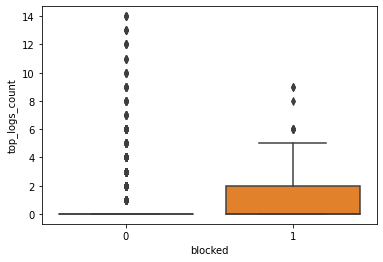

Статистики для группы blocked == 1


,top_logs_count
count,156.000000
mean,1.121795
std,1.942207
min,0.000000
25%,0.000000
50%,0.000000
75%,2.000000
max,9.000000


Медиана: 0.0
% пропусков в признаке для группы 1:           
77.7

Статистики для группы blocked == 0


,top_logs_count
count,2706.000000
mean,0.706578
std,1.808076
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,14.000000


Медиана: 0.0
% пропусков в признаке для группы 0:            
48.9


<AxesSubplot:xlabel='blocked', ylabel='top_logs_count'>

In [23]:
schow_feature_boxplots(concurent_logs_features.query('top_logs_count < 15'), 'top_logs_count')


In [24]:
#concurent_logs_features.merge(df_train, how='right').query('blocked == 1')['top_logs_count'].quantile(0.93)

Для группы оставшихся клиентов характерно частичное, хаотичное количество запросов к топовым доменам. При этом для ушедших оно более постоянно. 

Учитвая, что набор данных будет в пропусках заполнен нулями, на основе этого сделан призак "количество уникальных логов не 0 и больше 5", тк количество логов до 5 характерно для 93% ушедших клиентов. 

In [25]:
concurent_logs_features['top_logs_count_notnull_more5'] = concurent_logs_features['top_logs_count'].apply(
                                                            lambda x: 1 if x != 0 and x > 5 else 0)

In [26]:
df_train = df_train.merge(concurent_logs_features[['contract_id', 'top_logs_count',
                                                   'top_logs_count_notnull_more5']], how='left')

df_sample_solution = df_sample_solution.merge(concurent_logs_features[['contract_id', 'top_logs_count',
                                                   'top_logs_count_notnull_more5']], how='left')

### Извлечение признаков из родных логов 
Извлечение признаков из логов, собираемых компанией. 

In [27]:
#Базовые признаки количество уникальных логов

relative_logs_features = pd.DataFrame(df_relative_logs.groupby('contract_id')['event_type'].apply(set))

relative_logs_features['event_type'] = relative_logs_features['event_type'].apply(lambda x: len(x))
relative_logs_features.rename({'event_type':'unique_relative_logs_count'}, axis=1, inplace=True)

relative_logs_features = relative_logs_features.reset_index()
relative_logs_features

,contract_id,unique_relative_logs_count
0,3453,1
1,3454,1
2,3456,4
3,3457,1
4,3458,2
...,...,...
4306,274601,5
4307,274710,7
4308,274782,5
4309,274786,4


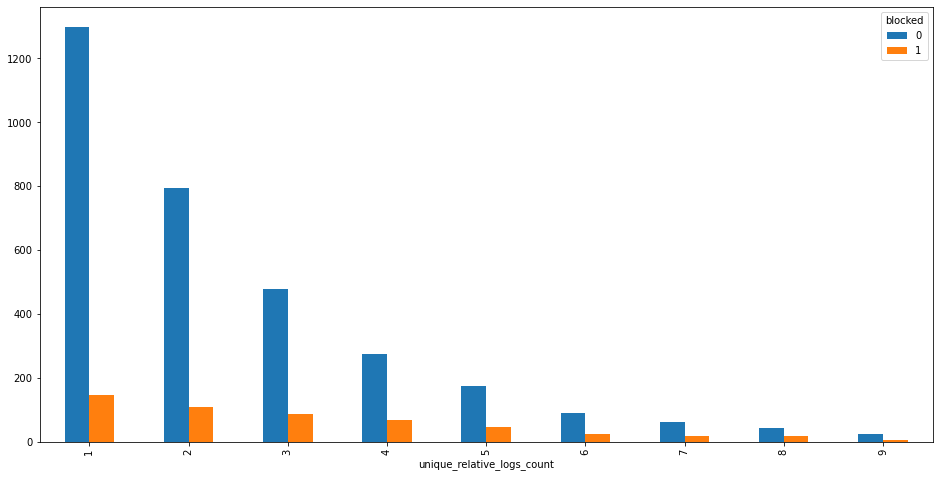

In [28]:
to_crosstab = relative_logs_features.merge(df_train[['contract_id', 
                            'blocked']]).query('unique_relative_logs_count < 10')

pd.crosstab(to_crosstab['unique_relative_logs_count'], to_crosstab['blocked']).plot(kind='bar', 
                                            figsize=(16, 8))

plt.show()

In [29]:
#Признак регистрировались ли родные логи

ids_with_logs = list(df_relative_logs.merge(df_train, how='left')['contract_id'])
relative_logs_features['have_relative_log'] = relative_logs_features['contract_id'].apply(
                                                        lambda x: 1 if x in ids_with_logs else 0)

#Количество логов всего 
total_relative_logs_data = pd.DataFrame(data=df_relative_logs.groupby('contract_id')
                                         ['event_type'].count()).reset_index()

total_relative_logs_data.rename({'event_type':'relative_logs_count'}, axis=1, inplace=True)

relative_logs_features = relative_logs_features.merge(total_relative_logs_data, how='outer')

relative_logs_features.head()

,contract_id,unique_relative_logs_count,have_relative_log,relative_logs_count
0,3453,1,1,1
1,3454,1,1,1
2,3456,4,1,4
3,3457,1,1,4
4,3458,2,1,23


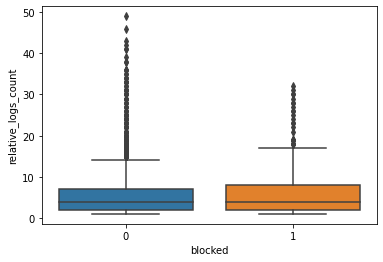

Статистики для группы blocked == 1


,relative_logs_count
count,535.000000
mean,5.857944
std,5.569312
min,1.000000
25%,2.000000
50%,4.000000
75%,8.000000
max,32.000000


Медиана: 4.0
% пропусков в признаке для группы 1:           
23.4

Статистики для группы blocked == 0


,relative_logs_count
count,3265.000000
mean,5.504441
std,5.549912
min,1.000000
25%,2.000000
50%,4.000000
75%,7.000000
max,49.000000


Медиана: 4.0
% пропусков в признаке для группы 0:            
38.3


<AxesSubplot:xlabel='blocked', ylabel='relative_logs_count'>

In [30]:
schow_feature_boxplots(relative_logs_features.query('relative_logs_count < 50'), feature='relative_logs_count')

Клиенты остающейся (0) группы более подвержены резкому большему количеству запросов в компанию более 7ми. Клиенты уходящие имеют распределение более широкое по разбросу (от 8 до 2 наблюдений), но более постоянное. 

**Извлечение признаков из природы логов.**

На основе анализа были выбраны признаки-слова: 

- информер — у остающихся клиентов доля обращений по турбокнопке больше, чем в группе ушедших. В группе остающихся доля — 33%, в группе ушедших доля 19%  

- бессмертие — у остающихся клиентов на данный запрос приходится 2% от общего количества логов, тогда как у уходящих 9%

Для признаков:
- забота, включение интернета на 20 минут, гарантированный платеж за деньги — поставлена гипотеза о влиянии частоты признаков на уход клиентов на основе вопросов:

Могут ли остающиеся клиенты чаще обращаться в службу заботы и быть более лояльными? \
Могут ли клиенты, желающие уйти, чаще включать интернет лишь на 20 минут? \
Остается ли постоянным количество запросов на гарантированный платеж из месяца в новый месяц? (исследование разницы)

In [31]:
df_relative_logs['immortality_in_url'] = df_relative_logs['event_type'].apply(
                                        lambda x: 1 if 'бессмертие' in x.lower() else 0
                                        )
df_relative_logs['informer_in_url'] = df_relative_logs['event_type'].apply(
                                        lambda x: 1 if 'информер' in x.lower() else 0
                                        )

df_relative_logs['care_in_url'] = df_relative_logs['event_type'].apply(
                                        lambda x: 1 if 'заботы' in x else 0
                                        )
df_relative_logs['internet20min_in_url'] = df_relative_logs['event_type'].apply(
                    lambda x: 1 if 'Включение интернета на 20 минут' in x else 0)

df_relative_logs['guaranteed_pay_in_url'] = df_relative_logs['event_type'].apply(
                    lambda x: 'Гарантированный платеж за деньги' in x)


word_relative_logs_features = df_relative_logs[['contract_id', 'informer_in_url', 'immortality_in_url',
                                                'care_in_url', 'internet20min_in_url',
                                                'guaranteed_pay_in_url'
                                                ]].groupby(
                                             'contract_id').sum().reset_index()

На основе анализа таблицы по собранным значениям, выявлено:

- наибольшее количество запросов о бессмертии — 0. Следовательно данный признак, если и включать, то только в виде "были ли запросы по логу "виртуальное бессмертие". 

- количество запросов по логу "Информер ВК" имеет схожее распределение в обоих группах. Отличие больше в том, что класса 1 меньше, что делает этот признак контринформативным, тем более что для данной структуры и природы данных необходим ресемплинг. 

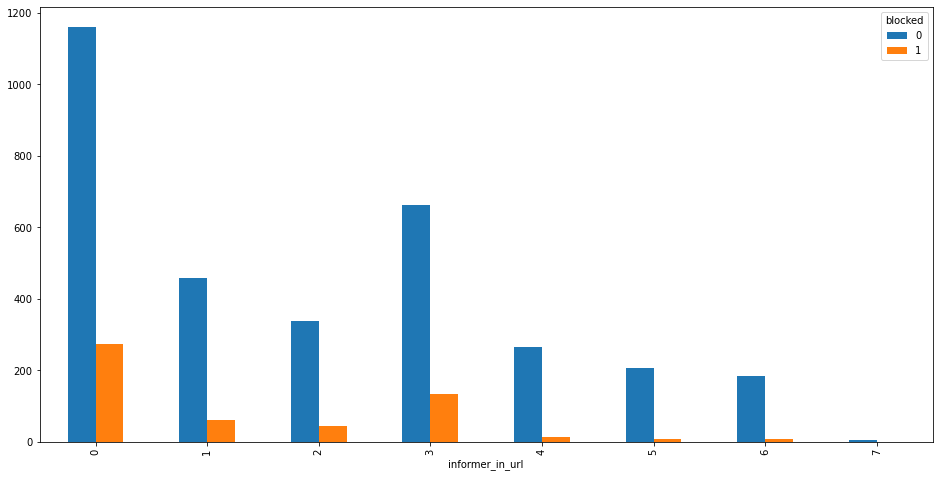

In [32]:
to_crosstab = word_relative_logs_features.merge(df_train[['contract_id', 
                            'blocked']])

pd.crosstab(to_crosstab['informer_in_url'], to_crosstab['blocked']).plot(kind='bar', 
                                            figsize=(16, 8))

plt.show()

word_relative_logs_features['informer_in_url'].value_counts()

word_relative_logs_features.drop(['informer_in_url'], axis=1, inplace=True)

In [33]:
relative_logs_features = relative_logs_features.merge(word_relative_logs_features, how='outer')

**Анализ признака забота на данных для тренировки.** 

Во избежание повторных запросов, из набора данных здесь, так как идет работа со временем в том числе, убраны секунды и вновь убраны появившиеся дубликаты. 

In [34]:
#выделение тренировочных id
train_ids = list(df_train['contract_id'].values)

#выделение месяца и дня
df_relative_logs['month'] = df_relative_logs['event_date'].dt.month
df_relative_logs['day'] = df_relative_logs['event_date'].dt.day

#Чистка секунд и удаление новых дубликатов
df_relative_logs['event_date_without_seconds'] = df_relative_logs['event_date'].dt.floor('Min')
df_relative_logs.drop('event_date', inplace=True, axis=1)

df_relative_logs.drop_duplicates(inplace=True)

In [35]:
#Выделение логов 

#Количество обращений в службу заботы о клиентах
data_to_cares_feature = df_relative_logs.groupby(['contract_id', 'month']).agg(
                              {'care_in_url': sum}
                              ).reset_index()


df_month3 = data_to_cares_feature.query('month == 3')
df_month4 = data_to_cares_feature.query('month == 4')

df_month3.rename({'month' : 'mart','care_in_url': 'mart_cares' }, axis=1, inplace=True)
df_month4.rename({'month' : 'april','care_in_url':'april_cares'}, axis=1, inplace=True)

cares_feature_data = df_month3.merge(df_month4, on='contract_id', how='outer').drop(['mart', 'april'], axis=1)



#Суммарное количество логов за два месяца
cares_feature_data['total_cares_logs_2_months'] = (cares_feature_data['mart_cares']+ 
                                                  cares_feature_data['april_cares'])



/Users/sad__sabrina/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [36]:
#schow_feature_boxplots(cares_feature_data, feature='mart_cares')
#schow_feature_boxplots(cares_feature_data, feature='april_cares')
#schow_feature_boxplots(cares_feature_data, feature='total_cares_logs_2_months')

Для ушедших клиетнтов видим более широкий характер распределения, однако приближение показвает, что основное количество обращений аккумулируется как раз в диапазоне от 0 до 1 за 2 месяца. 

В разрезе месяцев в марте клиенты ушедшие обращались с более резким паттерном к частым запросам, чем клиенты оставшиеся, следовательно возможно данный признак стоит рассмотреть на большем отрезке времени. 

На основе комбинации для оставшихся клиентов (0) виден более постоянным паттерн большего количества запросов. В качестве признаков можно рассмотреть: 

- общее количество запросов за 2 месяца
- границу, "больше 4х запросов"

**Анализ признака информер ВК**

In [37]:
#Суммарное количество по клиентам

data_to_informer_feature = df_relative_logs.groupby(['contract_id', 'month']).agg(
                              {'informer_in_url': sum}
                              ).reset_index()

#Обращения по запросу в месяц
df_month3 = data_to_informer_feature.query('month == 3')
df_month4 = data_to_informer_feature.query('month == 4')

df_month3.rename({'month' : 'mart','informer_in_url': 'mart_informers' }, axis=1, inplace=True)
df_month4.rename({'month' : 'april','informer_in_url':'april_informers'}, axis=1, inplace=True)


informer_feature_data = df_month3.merge(df_month4, on='contract_id', how='outer').drop(['mart',
                                                                 'april'], axis=1)
#Обращения по запросу за 2 месяца
informer_feature_data['total_informer_logs_2_months'] = (informer_feature_data['mart_informers']+ 
                                                          informer_feature_data['april_informers'])

informer_feature_data

,contract_id,mart_informers,april_informers,total_informer_logs_2_months
0,3453,1.0,NaN,NaN
1,3456,0.0,NaN,NaN
2,3457,3.0,1.0,4.0
3,3458,0.0,0.0,0.0
4,3459,0.0,3.0,3.0
...,...,...,...,...
4306,274601,NaN,1.0,NaN
4307,274710,NaN,1.0,NaN
4308,274782,NaN,0.0,NaN
4309,274786,NaN,2.0,NaN


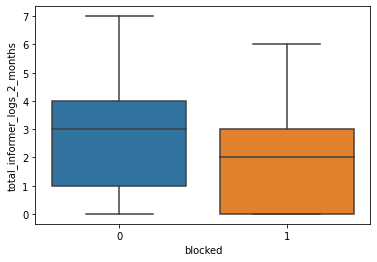

Статистики для группы blocked == 1


,total_informer_logs_2_months
count,178.000000
mean,1.859551
std,1.656163
min,0.000000
25%,0.000000
50%,2.000000
75%,3.000000
max,6.000000


Медиана: 2.0
% пропусков в признаке для группы 1:           
74.5

Статистики для группы blocked == 0


,total_informer_logs_2_months
count,1686.000000
mean,2.613286
std,1.978499
min,0.000000
25%,1.000000
50%,3.000000
75%,4.000000
max,7.000000


Медиана: 3.0
% пропусков в признаке для группы 0:            
68.2


<AxesSubplot:xlabel='blocked', ylabel='total_informer_logs_2_months'>

In [38]:
schow_feature_boxplots(informer_feature_data, 'total_informer_logs_2_months')

В разрезе отдельных признаков по месяцам информативности нет. В разрезе суммы видно, что остающиеся (0) клиенты чаще образащаются по информеру **не 1 раз** за два месяца. На пробу взята граница отсечения и признак "более 3х обращений за 2 месяца"

In [39]:
informer_feature_data['total_informer_logs_2_months_more3'] =  informer_feature_data[
    'total_informer_logs_2_months'].apply(lambda x: 1 if x >=3 else 0)

**Анализ признака гарантированный платеж**

In [40]:
guaranteed_pay_month_df = pd.pivot_table(df_relative_logs.query('guaranteed_pay_in_url == 1'), columns='month', index='contract_id',
               values='event_date_without_seconds', aggfunc='count') #.fillna(0).reset_index()

guaranteed_pay_month_df['difference_in_pay_logs'] = (guaranteed_pay_month_df[3] - guaranteed_pay_month_df[4])

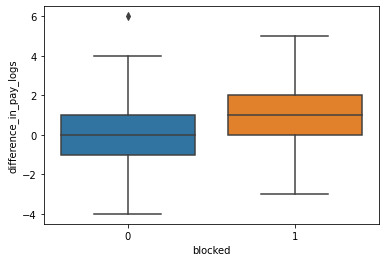

Статистики для группы blocked == 1


,difference_in_pay_logs
count,33.000000
mean,1.000000
std,1.785357
min,-3.000000
25%,0.000000
50%,1.000000
75%,2.000000
max,5.000000


Медиана: 1.0
% пропусков в признаке для группы 1:           
95.3

Статистики для группы blocked == 0


,difference_in_pay_logs
count,301.000000
mean,0.119601
std,1.444177
min,-4.000000
25%,-1.000000
50%,0.000000
75%,1.000000
max,6.000000


Медиана: 0.0
% пропусков в признаке для группы 0:            
94.3


<AxesSubplot:xlabel='blocked', ylabel='difference_in_pay_logs'>

In [41]:
schow_feature_boxplots(guaranteed_pay_month_df, 'difference_in_pay_logs')

Различные уровни распределений явно видны визуально. 

**Анализ логов по одним и тем-же запросам в разрезе 1го id** 

In [42]:
analysis_sample = df_relative_logs.query('contract_id in @train_ids').query('informer_in_url == 0')

repeated_logs_сount = pd.pivot_table(analysis_sample, index=['contract_id'],
               columns='event_type', values='event_date_without_seconds', aggfunc='count').fillna(0).replace(1.0, 0.0)

repeated_logs_сount['repeated_logs_count'] = [sum(repeated_logs_сount.iloc[i, :] != 0) 
                                              for i in range(0, len(repeated_logs_сount))]

In [43]:
repeated_logs_сount = repeated_logs_сount.iloc[:, :].reset_index()
#schow_feature_boxplots(repeated_logs_сount, 'repeated_logs_count')

Распределение признаков в сумме визуально не выглядит иформативным. Рассмотрим разрез по месяцам. 

In [44]:
repeated_logs_сount_month_data = pd.pivot_table(analysis_sample, index=['contract_id', 'month'],
               columns='event_type', values='event_date_without_seconds', 
               aggfunc='count').fillna(0).reset_index().replace(1.0, 0.0)

repeated_logs_сount_month_data['repeated_logs_count'] = [sum(repeated_logs_сount_month_data.iloc[i, 2:] != 0) 
                                    for i in range(0, len(repeated_logs_сount_month_data))]

#Среднее количество повторяющихся логов по месяцам
repeated_logs_сount_month_data = repeated_logs_сount_month_data[['contract_id', 'month', 
                                                                 'repeated_logs_count']]

repeated_logs_сount_month_data.columns = ['contract_id', 'month', 'repeated_logs_count']

In [45]:
repeated_logs_сount_mart_data = repeated_logs_сount_month_data.query('month == 3')
repeated_logs_сount_april_data = repeated_logs_сount_month_data.query('month == 4')


repeated_logs_сount_mart_data.rename({'repeated_logs_count': 'mart_repeated_logs_count'}, axis=1, inplace=True
                  )


repeated_logs_сount_april_data.rename({'repeated_logs_count': 'april_repeated_logs_count'}, axis=1, inplace=True
                  )


repeated_logs_сount_month_data = repeated_logs_сount_mart_data[['contract_id', 'mart_repeated_logs_count']].merge(
                            repeated_logs_сount_april_data[['contract_id', 'april_repeated_logs_count']],
                             how='outer').fillna(0)

repeated_logs_сount_month_data['mean_repeated_logs_2_months'] = (repeated_logs_сount_month_data['mart_repeated_logs_count'] + 
                                                           repeated_logs_сount_month_data['april_repeated_logs_count']
                                                            )/2

repeated_logs_сount_month_data.head()

/Users/sad__sabrina/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,contract_id,mart_repeated_logs_count,april_repeated_logs_count,mean_repeated_logs_2_months
0,7780,0.0,2.0,1.0
1,7785,0.0,0.0,0.0
2,7795,1.0,0.0,0.5
3,7807,0.0,0.0,0.0
4,7819,0.0,0.0,0.0


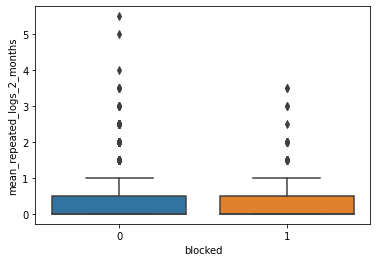

Статистики для группы blocked == 1


,mean_repeated_logs_2_months
count,505.000000
mean,0.320792
std,0.535508
min,0.000000
25%,0.000000
50%,0.000000
75%,0.500000
max,3.500000


Медиана: 0.0
% пропусков в признаке для группы 1:           
27.7

Статистики для группы blocked == 0


,mean_repeated_logs_2_months
count,2540.000000
mean,0.360039
std,0.578598
min,0.000000
25%,0.000000
50%,0.000000
75%,0.500000
max,5.500000


Медиана: 0.0
% пропусков в признаке для группы 0:            
52.0


<AxesSubplot:xlabel='blocked', ylabel='mean_repeated_logs_2_months'>

In [46]:
schow_feature_boxplots(repeated_logs_сount_month_data, 'mean_repeated_logs_2_months')

В разрезе месяцев распределения также не информативны, однако для попытки уловить разницу взяты признаки "общее количество повторяющихся логов за 2 меясца", "среднее количество повторяющихся логов за два месяца". 

In [47]:
repeated_logs_сount_month_data['total_repeated_logs_2_months'] = (repeated_logs_сount_month_data['mart_repeated_logs_count'] + 
                                                           repeated_logs_сount_month_data['april_repeated_logs_count']
                                                            )

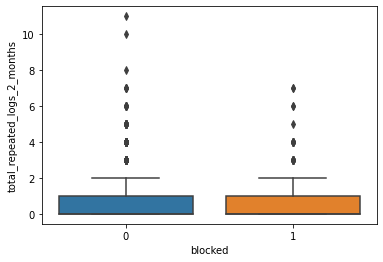

Статистики для группы blocked == 1


,total_repeated_logs_2_months
count,505.000000
mean,0.641584
std,1.071017
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,7.000000


Медиана: 0.0
% пропусков в признаке для группы 1:           
27.7

Статистики для группы blocked == 0


,total_repeated_logs_2_months
count,2540.000000
mean,0.720079
std,1.157195
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,11.000000


Медиана: 0.0
% пропусков в признаке для группы 0:            
52.0


<AxesSubplot:xlabel='blocked', ylabel='total_repeated_logs_2_months'>

In [48]:
schow_feature_boxplots(repeated_logs_сount_month_data, 'total_repeated_logs_2_months')

**Сборка наборов данных по признакам**

In [49]:
relative_logs_features

,contract_id,unique_relative_logs_count,have_relative_log,relative_logs_count,immortality_in_url,care_in_url,internet20min_in_url,guaranteed_pay_in_url
0,3453,1,1,1,0,0,0,0
1,3454,1,1,1,0,0,0,0
2,3456,4,1,4,0,0,0,0
3,3457,1,1,4,0,0,0,0
4,3458,2,1,23,0,0,3,20
...,...,...,...,...,...,...,...,...
4306,274601,5,1,6,0,2,1,0
4307,274710,7,1,7,0,0,0,0
4308,274782,5,1,8,0,4,0,0
4309,274786,4,1,9,0,5,1,0


In [50]:
#Присоединение care

relative_logs_features = relative_logs_features.merge(
                            cares_feature_data[['contract_id', 'total_cares_logs_2_months']], 
                            how='left').fillna(0)

#Присоеднинение informer
relative_logs_features = relative_logs_features.merge(
                            informer_feature_data[['contract_id', 'total_informer_logs_2_months',
                            'total_informer_logs_2_months_more3']], 
                            how='left').fillna(0)

##Присоеднинение pay
relative_logs_features = relative_logs_features.merge(
                            guaranteed_pay_month_df.reset_index()[['contract_id', 'difference_in_pay_logs']], 
                            how='left').fillna(0)

In [51]:
#Присоеднинение repeated_logs
relative_logs_features = relative_logs_features.merge(
                            repeated_logs_сount_month_data[['contract_id', 'mean_repeated_logs_2_months',
                                                           'total_repeated_logs_2_months']], 
                            how='left').fillna(0)

relative_logs_features = relative_logs_features.merge(
                            repeated_logs_сount[['contract_id', 'repeated_logs_count']], 
                            how='left').fillna(0)

**Признак: количество повторяющихся запросов в день**

In [52]:
repeated_logs_in_day = pd.pivot_table(df_relative_logs.query('contract_id in @train_ids'), 
               index='contract_id', values='event_type', columns='day', aggfunc='count'
                                     ).fillna(0).replace(1.0, 0).reset_index()

repeated_logs_in_day['days_with_repeated_logs_count'] = [
    sum(repeated_logs_in_day.iloc[i, 1:] != 0) for i in range(0, len(repeated_logs_in_day))]

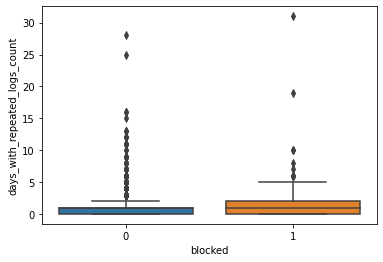

Статистики для группы blocked == 1


,days_with_repeated_logs_count
count,537.000000
mean,1.327747
std,2.020564
min,0.000000
25%,0.000000
50%,1.000000
75%,2.000000
max,31.000000


Медиана: 1.0
% пропусков в признаке для группы 1:           
23.1

Статистики для группы blocked == 0


,days_with_repeated_logs_count
count,3272.000000
mean,1.205685
std,1.695443
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,28.000000


Медиана: 1.0
% пропусков в признаке для группы 0:            
38.2


<AxesSubplot:xlabel='blocked', ylabel='days_with_repeated_logs_count'>

In [53]:
schow_feature_boxplots(repeated_logs_in_day, 'days_with_repeated_logs_count')

Для группы уходящих клиентов постоянное количество дней с более чем одним логом более широко, даже не смотря на то, что класс в наборе данных в минорном количестве. 

In [54]:
repeated_logs_in_day['total_repeated_logs_count'] = (repeated_logs_in_day.iloc[:, 1:32]).sum(axis=1)

repeated_logs_in_day['mean_repeated_logs_in_day'] = round(repeated_logs_in_day[
                    'total_repeated_logs_count']/repeated_logs_in_day[
                     'days_with_repeated_logs_count'])

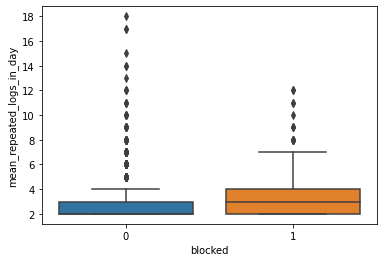

Статистики для группы blocked == 1


,mean_repeated_logs_in_day
count,383.000000
mean,3.415144
std,1.819752
min,2.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,12.000000


Медиана: 3.0
% пропусков в признаке для группы 1:           
45.1

Статистики для группы blocked == 0


,mean_repeated_logs_in_day
count,2135.000000
mean,2.897892
std,1.557962
min,2.000000
25%,2.000000
50%,2.000000
75%,3.000000
max,18.000000


Медиана: 2.0
% пропусков в признаке для группы 0:            
59.7


<AxesSubplot:xlabel='blocked', ylabel='mean_repeated_logs_in_day'>

In [55]:
#Также добавлен признак среднее количество повторяющихся логов на день

schow_feature_boxplots(repeated_logs_in_day, 'mean_repeated_logs_in_day')

In [56]:
#Сборка полученных признаков в единую таблицу

repeated_logs_in_day = repeated_logs_in_day[['contract_id', 'days_with_repeated_logs_count',
                                             'mean_repeated_logs_in_day']].query(
                                            'days_with_repeated_logs_count <= 60')

relative_logs_features = relative_logs_features.merge(repeated_logs_in_day, 
                                                      on = 'contract_id',how='outer').fillna(0) 

### Формирование обучающих и тестовых данных. 

In [57]:
df_train = df_train.merge(df_type_contract, on='contract_id', how='left')
df_train = df_train.merge(relative_logs_features, on = 'contract_id',how='left').fillna(0) 


In [58]:
len(df_train.columns)

27

In [59]:
final_test_data = df_sample_solution.merge(df_type_contract, on='contract_id', how='left')
final_test_data = final_test_data.merge(relative_logs_features, on = 'contract_id',how='left').fillna(0) 

In [60]:
len(final_test_data.columns)

27

In [61]:
#final_test_data.drop(['blocked', 'contract_id'],axis=1, inplace=True)

In [62]:
#df_train.to_csv('current_train.csv')
#final_test_data.to_csv('test.csv')

### Базовое обучение

In [64]:
print('Классы в тренировочном наборе данных')

df_train['blocked'].value_counts()

Классы в тренировочном наборе данных


0    5294
1     698
Name: blocked, dtype: int64

In [67]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, classification_report
from sklearn.model_selection import train_test_split


#Срез сэмпла для обучения алгоритма
#Необходим для устранения сильного ребаланса
df_train_sample = df_train.query('blocked==0').sample(1000, 
                 random_state=7).append(df_train.query('blocked==1')).fillna(0)

#Определение матрицы признаков и вектора целевой переменной
X = df_train_sample.drop(["contract_id", "blocked"], axis = 1)
y = df_train_sample[["blocked"]]

#Разбиение датасета так, чтобы спрятать независимый кусочек для ещё одного тестирования, помимо валидации
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

#Определение алгоритма
classic_random_forest = RandomForestClassifier(random_state=1, n_estimators=200, max_depth=11,
                             criterion="entropy")

classic_random_forest.fit(X_train, y_train)

predictions = classic_random_forest.predict(X_test)

print("Recall score:", recall_score(y_test, predictions, average='macro'))

/var/folders/44/m5wkyqf96jjfs5d97lqgk_q00000gn/T/ipykernel_3747/1678379761.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  classic_random_forest.fit(X_train, y_train)


Recall score: 0.7127039627039626


<AxesSubplot:>

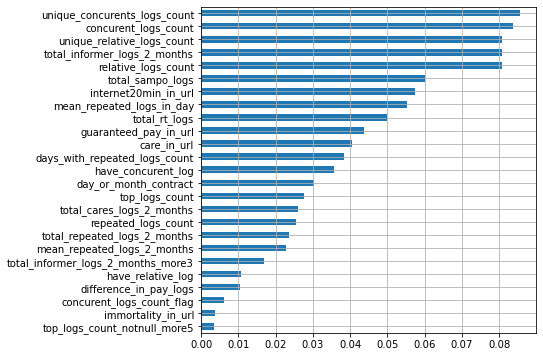

In [68]:
pd.DataFrame(data={'score': classic_random_forest.feature_importances_}, 
                      index=classic_random_forest.feature_names_in_).sort_values(by='score').plot(kind='barh', grid=True,
                                               figsize=(6,6), legend=False)